In [1]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_cluster_abundance_improved as cl_count

# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [3]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)

## Hyper-parameters (non-cosmo)

In [4]:
#purity
richness0, p0, p1, np_ = 40, 0, 0, 1
theta_purity = [richness0, p0, p1, np_]
#completeness
logm0, c0, c1, nc = 13.5, 0, 0, 1
theta_completeness = [logm0, c0, c1, nc]
#rm_relation
log10m0, z0 = 13.5, .4
proxy_mu0, proxy_muz, proxy_mulog10m =  np.log(20), 0, 2
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  .5, 0., 0
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [5]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 500)
logm_grid = np.linspace(13, 16, 501)
z_grid = np.linspace(.1, 1, 502)

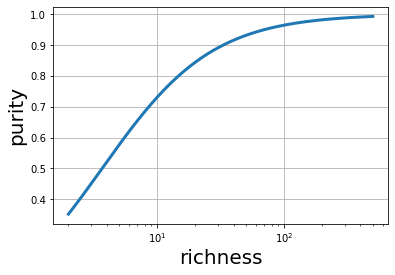

In [6]:
plt.plot(richness_grid, cl_count.purity(richness_grid, .4, theta_purity), linewidth=3)
plt.xlabel('richness', fontsize=20)
plt.ylabel('purity', fontsize=20)
plt.grid(True)
plt.xscale('log')

# Completeness

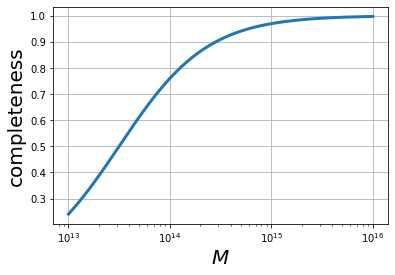

In [7]:
plt.plot(10**logm_grid, cl_count.completeness(logm_grid, .4, theta_completeness), linewidth=3)
plt.xlabel(r'$M$', fontsize=20)
plt.ylabel('completeness', fontsize=20)
plt.xscale('log')
plt.grid(True)

# Richness-mass relation

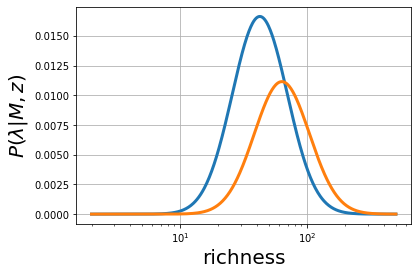

In [8]:
plt.plot(richness_grid, cl_count.richness_mass_relation(richness_grid, 14, .4, theta_rm), linewidth=3)
plt.plot(richness_grid, cl_count.richness_mass_relation(richness_grid, 14.2, .4, theta_rm), linewidth=3)
plt.xlabel('richness', fontsize=20)
plt.ylabel(r'$P(\lambda|M, z)$', fontsize=20)
plt.grid(True)
plt.xscale('log')

# Cluster Abundance

In [9]:
z_edges = np.linspace(0.1, 1, 5)
Z_bin = binning(z_edges)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 11))
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [10]:
case = [[False, False], [False, True], [True, False], [True, True]]
add = []
N_ = []
for i, c in enumerate(case):
    N0, p0 = cl_count. abundance_proxy(
                     #bins
                     Z_bin, Richness_bin, 
                     #params cosmo
                     cosmo, hmd,
                     #params non-cosmo
                     theta_purity, theta_completeness, theta_rm,
                     #tabulated axis
                     richness_grid, logm_grid, z_grid,
                     #grids (reshaped)
                     dNdzdlogMdOmega=None, 
                     purity=None,  
                     completeness=None,  
                     richness_mass_relation=None, 
                     #add ?
                     add_purity=c[0],
                     add_completeness=c[1],
                     #to be re-computed ?
                     compute_dNdzdlogMdOmega=True, 
                     compute_purity=True, 
                     compute_completeness=True,  
                     compute_richness_mass_relation=True )
    add.append(simps(p0, logm_grid, axis=1))
    N_.append(N0)

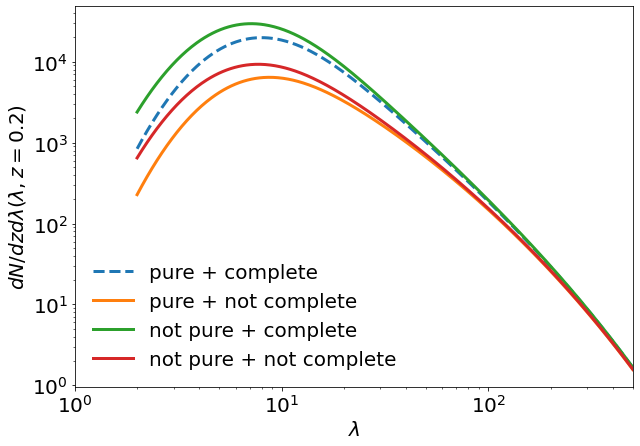

In [11]:
plt.figure(figsize=(10, 7))
fmt = ['--', '-', '-', '-']
for i, c in enumerate(case):
    legend = ''
    if c[0] == True:
        legend = legend + 'not pure + '
    else:
        legend = legend + 'pure + '
    if c[1] == True:
        legend = legend + 'not complete'
    else:
        legend = legend + 'complete'
    plt.loglog(richness_grid, add[i][:,30], fmt[i], label=legend, linewidth=3)
    
plt.ylabel(f'$dN/dzd\lambda(\lambda, z = {z_grid[30]:.1f})$', fontsize=20)
plt.xlabel('$\lambda$', fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.xlim(1, 500)
plt.tick_params(axis='both', which="both", labelsize= 20)

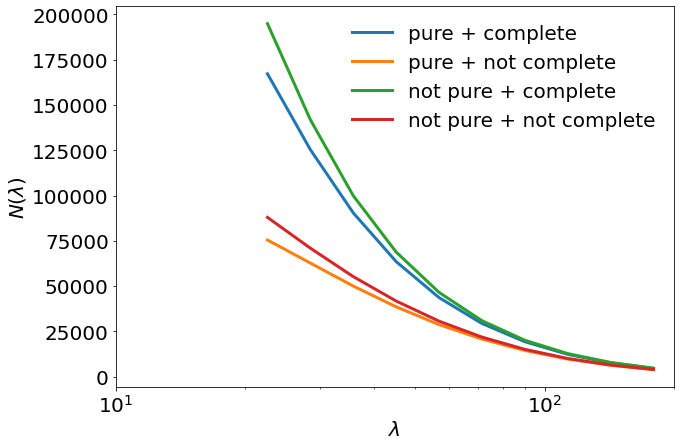

In [12]:
plt.figure(figsize=(10, 7))
fmt = ['--', '-', '-', '-']
for i, c in enumerate(case):
    legend = ''
    if c[0] == True:
        legend = legend + 'not pure + '
    else:
        legend = legend + 'pure + '
    if c[1] == True:
        legend = legend + 'not complete'
    else:
        legend = legend + 'complete'
    f = .25
    plt.plot(np.mean(Richness_bin, axis=1), f*(4*np.pi)*N_[i][:,2], label=legend, linewidth=3)
plt.xscale('log')
plt.ylabel(r'$N(\lambda)$', fontsize=20)
plt.xlim(10, 200)
plt.xlabel('$\lambda$', fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.tick_params(axis='both', which="both", labelsize= 20)

# *Mass-redshift bins

In [13]:
logm_edges = np.linspace(14.2, 15.5, 5)
Logm_bin = binning(logm_edges)

In [14]:
N0, p0 = cl_count.abundance_mass(Z_bin, Logm_bin, 
                   cosmo, hmd, 
                   theta_completeness,
                   logm_grid, z_grid,
                   dNdzdlogMdOmega=None, 
                   completeness=None, 
                   add_completeness=False,
                   compute_dNdzdlogMdOmega=True, 
                   compute_completeness=True)

## Test with Pinocchio data

In [15]:
import os
import pandas as pd

where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
file=glob.glob(where_cat)[1]
dat = pd.read_csv(file ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
pos_ra, pos_dec = dat['ra'], dat['dec']
f_sky = 1/4

In [16]:
m = np.histogram2d(np.log10(dat['M']/cosmo['h']), dat['z'], bins = [logm_edges, z_edges])
N_obs = m[0]

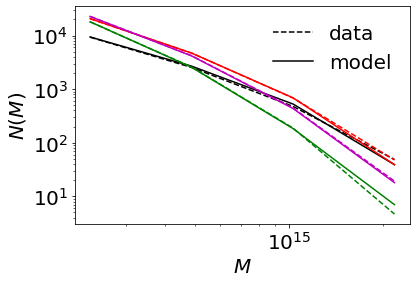

In [17]:
c = ['k', 'r', 'm', 'g']
for i in range(len(Z_bin)):
    plt.plot(10**np.mean(Logm_bin, axis=1), N_obs[:,i], c=c[i])
    plt.loglog(10**np.mean(Logm_bin, axis=1), f_sky*4*np.pi*N0[:,i], '--',c=c[i])
plt.plot([], [], '--k', label='data')
plt.plot([], [], '-k', label='model')
plt.ylabel(r'$N(M)$', fontsize=20)
plt.xlabel('$M$', fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.tick_params(axis='both', which="both", labelsize= 20)